In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/unimodal/orig_0_1_2_cnmp/1716801204'

data_path = root_path + test_path + '/y_all.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')


# Y_means = np.zeros((4,Y.shape[1]))
# for i in range(4):
#     Y_means[i] = np.mean(Y[i*32:(i+1)*32], axis=0)

x: (100,), Y: (30, 100)


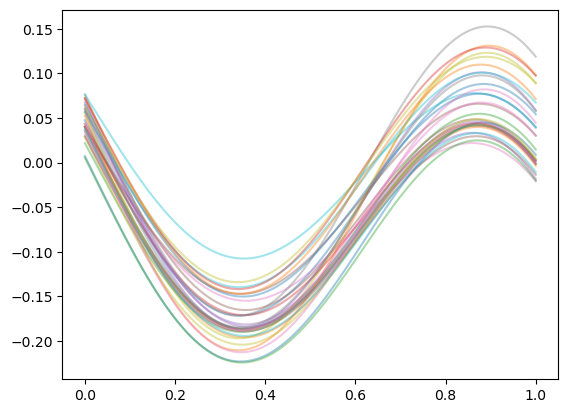

In [3]:
# plot Y and Y_means
plt.plot(x, Y.T, label='Y', alpha=0.4)
# plt.plot(x, Y_means.T, label='Y_means', alpha=0.5)
plt.show()

In [4]:
def find_closest_traj_ind(traj):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    for i, y in enumerate(Y):
        dist = np.linalg.norm(y - traj)  # euclidean distance between two trajectories
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind


def compute_rmse(traj0, traj1):
    # RMSE between two trajs
    return np.sqrt(np.mean((traj0 - traj1) ** 2))


def compute_mae(traj0, traj1):
    # MAE between two trajs
    return np.mean(np.abs(traj0 - traj1))


def compute_max_error(traj0, traj1):
    # maximum error between two trajs
    return np.max(np.abs(traj0 - traj1))

In [5]:
root_path = f"{root_path}/ablation/unimodal/orig_0_1_2_cnmp/"
run_id, model_folder = '1716801204', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 6, 6
t_steps = 100
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [64,64], decoder_hidden_dims=[64,64], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=1, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)
val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)

In [6]:
from tqdm import tqdm

num_tests = 100

# y0 = np.mean(Y[:, 0])
# y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y_min, y_max = np.min(Y[:, 0]), np.max(Y[:, 0])
y1 = np.mean(Y[:, -1])

ys = np.linspace(y_min, y_max, num_tests)

num_models = 10
# 0: DMP, 1: ProMP, 2: GMR, 3: CNMP, 4: StableMP, 5:CNEP, 6: CNEP-MoE, 7: CNEP-A0, 8: CNEP-A1, 9: CNEP-A2

rmse_errors = np.zeros((num_tests, num_models))  # num_models models
mae_errors = np.zeros((num_tests, num_models))
max_errors = np.zeros((num_tests, num_models))

for i in tqdm(range(num_tests)):
    d = DMP(n_dims=1, n_weights_per_dim=20)

    for i, traj in enumerate(Y):
        d.imitate(x, traj.reshape(-1,1))

    p = ProMP(n_dims=1, n_weights_per_dim=20)
    p.imitate(np.tile(x, (30, 1)), Y)

    input_data = x.reshape(-1, 1)  # Phase variable as a column vector

    priors = 20  # Number of GMM components
    gmr_model = GMM(n_components=priors, random_state=1234)
    gmr_model.from_samples(Y)


    y0 = ys[i]

    # DMP
    d.configure(start_y=[y0], goal_y=[y1])
    t, trajectory = d.open_loop()

    # ProMP
    p = p.condition_position(y0, t=0).condition_position(y1, t=1)
    trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

    # GMR
    gmr_model_ = gmr_model.condition([0, -1], [y0, y1])
    trajectory_g = gmr_model_.sample(1)
    trajectory_g = np.insert(trajectory_g, 0, y0)
    trajectory_g = np.append(trajectory_g, y1)

    # CNMP and CNEP
    val_obs[0, :2, dx:] = torch.tensor([y0, y1]).unsqueeze(1)

    with torch.no_grad():
        trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
        pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
        dec_id = torch.argmax(gate.squeeze(1), dim=-1)
        trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

        confs = gate.view(1, 1, 1, 1)
        preds = pred_cnep[:, :, :, :dy]

        weighted_preds = preds * confs  # Element-wise multiplication, shape (4, 1, 200, 1)
        trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

        pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
        dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
        trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

        pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
        dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
        trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

        pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
        dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
        trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]


    for j in range(num_models):
        if j == 0:
            traj = trajectory
        elif j == 1:
            traj = trajectory_p.squeeze(0)
        elif j == 2:
            traj = trajectory_g
        elif j == 3:
            traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
        elif j == 4:
            pass  # can't load StableMP, run offline and read from file
        elif j == 5:
            traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
        elif j == 6:
            traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
        elif j == 7:
            traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
        elif j == 8:
            traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
        elif j == 9:
            traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

        closest_traj_ind = find_closest_traj_ind(traj)

        rmse_errors[i, j] = compute_rmse(traj, Y[closest_traj_ind])
        mae_errors[i, j] = compute_mae(traj, Y[closest_traj_ind])
        max_errors[i, j] = compute_max_error(traj, Y[closest_traj_ind])

In [7]:
# print mean errors and standard deviations
print('RMSE')
print(np.mean(rmse_errors, axis=0))
print(np.std(rmse_errors, axis=0))
print('MAE')
print(np.mean(mae_errors, axis=0))
print(np.std(mae_errors, axis=0))
print('Max error')
print(np.mean(max_errors, axis=0))
print(np.std(max_errors, axis=0))

RMSE
[0.0010525  0.0011142  0.00011693 0.00552474 0.00552474 0.00544684
 0.00544684 0.00573293 0.00571783 0.00555651]
[0.01047223 0.01108615 0.00116342 0.0549705  0.0549705  0.05419539
 0.05419539 0.05704192 0.05689172 0.05528658]
MAE
[0.0008626  0.00092545 0.00011503 0.00503089 0.00503089 0.00495369
 0.00495369 0.00524512 0.00522662 0.00506339]
[0.00858272 0.0092081  0.00114449 0.05005669 0.05005669 0.04928857
 0.04928857 0.05218825 0.05200418 0.05038011]
Max error
[0.00230113 0.00228239 0.00016514 0.00884825 0.00884825 0.00876192
 0.00876192 0.00907223 0.0090613  0.00888344]
[0.02289598 0.02270946 0.00164314 0.08803894 0.08803894 0.08718003
 0.08718003 0.09026751 0.09015877 0.08838909]


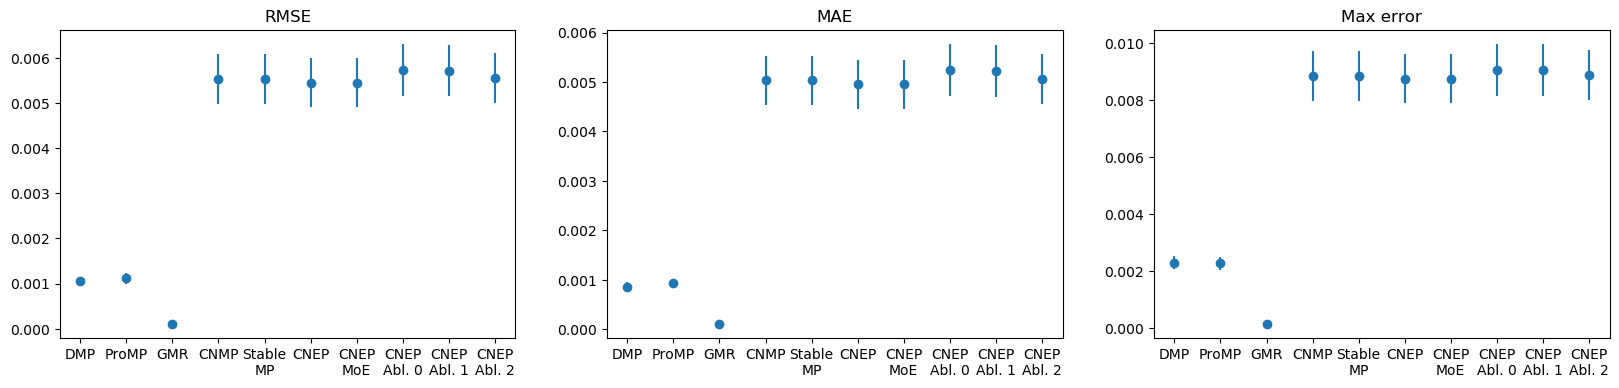

In [12]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
ax[0].set_title('RMSE')
ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()

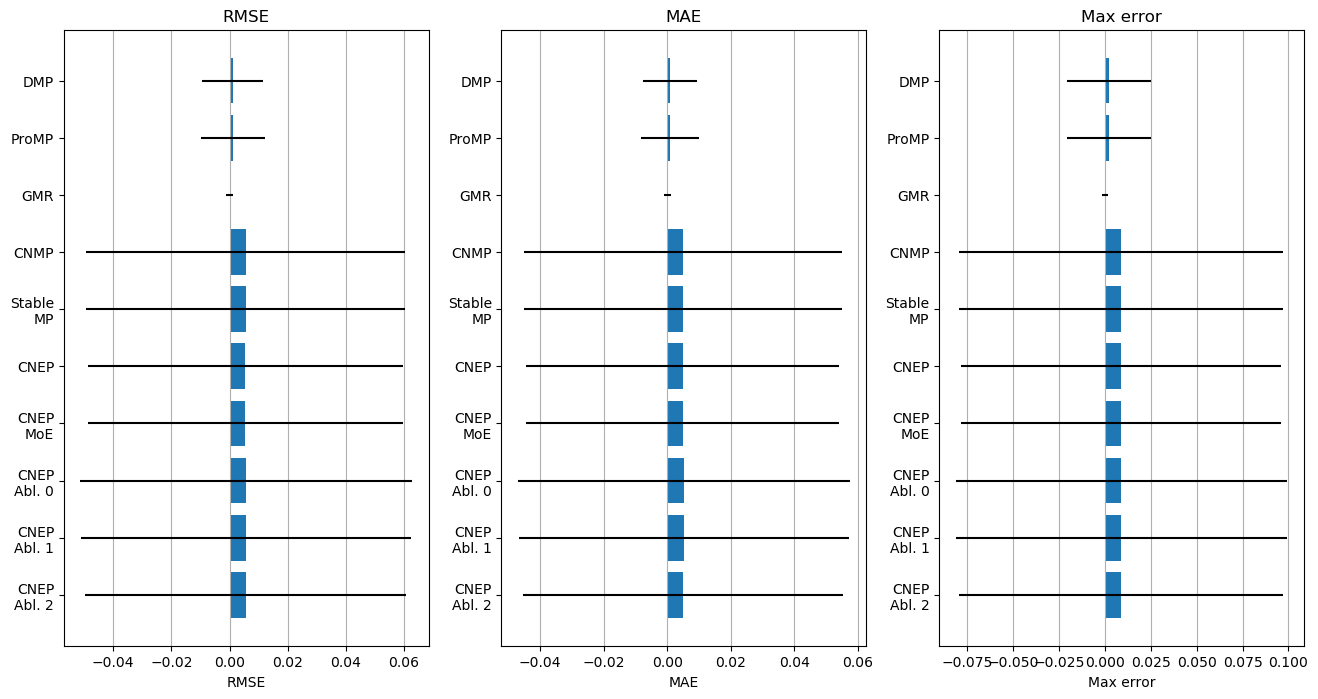

In [11]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(rmse_errors, axis=0), xerr=np.std(rmse_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('RMSE')
ax[0].set_title('RMSE')
ax[1].barh(y_pos, np.mean(mae_errors, axis=0), xerr=np.std(mae_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(max_errors, axis=0), xerr=np.std(max_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()